# 1-1 Example: Modeling Procedure for Structured Data (Day-1)

Welcome to Day 1 of the "Eat That TensorFlow2.0 in 30 Days" series on Kaggle!

Today, we'll dive into the Modeling Procedure of TensorFlow, laying the foundation for our TensorFlow journey. In this chapter, we'll start with a practical example of modeling structured data. Get ready to learn the essentials of TensorFlow modeling in just a few lines of code! 🚀🤩

### 1. Data Preparation


The purpose of the Titanic dataset is to predict whether the given passengers could be survived after Titinic hit the iceburg titanic, according to their personal information.

We usually use DataFrame from the pandas library to pre-process the structured data.

In [1]:
!pip install tensorflow -q

In [2]:
import warnings
warnings.filterwarnings('ignore',category=UserWarning)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
import plotly.express as px
import plotly.graph_objs as go
from tensorflow.keras import models,layers
from sklearn.model_selection import train_test_split

In [3]:
dftrain_raw = pd.read_csv('/kaggle/input/titanic/train.csv')
dftest_raw = pd.read_csv('/kaggle/input/titanic/test.csv')
dftrain_raw.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Introduction of each field：

* Survived: 0 for death and 1 for survived [y labels]
* Pclass: Class of the tickets, with three possible values (1,2,3) [converting to one-hot encoding]
* Name: Name of each passenger [discarded]
* Sex: Gender of each passenger [converting to bool type]
* Age: Age of each passenger (partly missing) [numerical feature, should add "Whether age is missing" as auxiliary feature]
* SibSp: Number of siblings and spouse of each passenger (interger) [numerical feature]
* Parch: Number of parents/children of each passenger (interger) [numerical feature]
* Ticket: Ticket number (string) [discarded]
* Fare: Ticket price of each passenger (float, between 0 to 500) [numerical feature]
* Cabin: Cabin where each passenger is located (partly missing) [should add "Whether cabin is missing" as auxiliary feature]
* Embarked: Which port was each passenger embarked, possible values are S、C、Q (partly missing) [converting to one-hot encoding, four dimensions, S,C,Q,nan]

Use data visualization for initial EDA (Exploratory Data Analysis).

Survival label distribution:

In [4]:
%matplotlib inline
# Count the values of 'Survived' column
counts = dftrain_raw['Survived'].value_counts()

# Create the bar chart using Plotly Express
fig = px.bar(x=counts.index, y=counts.values,
             labels={'x': 'Survived', 'y': 'Counts'},
             title='Survived Counts',
             width=800, height=500)

# Show the plot
fig.show()

Age distribution:

In [5]:
# Create the histogram using Plotly Express
fig = px.histogram(dftrain_raw, x='Age', nbins=20, color_discrete_sequence=['purple'],
                   labels={'Age': 'Age', 'count': 'Frequency'},
                   title='Age Distribution',
                   width=800, height=500)

# Show the plot
fig.show()

Correlation between age and survival label:

In [6]:
# Create the traces for both 'Survived==0' and 'Survived==1'
trace_survived_0 = go.Histogram(x=dftrain_raw.query('Survived == 0')['Age'], opacity=0.7,
                                name='Survived==0', marker=dict(color='red'))
trace_survived_1 = go.Histogram(x=dftrain_raw.query('Survived == 1')['Age'], opacity=0.7,
                                name='Survived==1', marker=dict(color='green'))

# Create the figure with the overlaid density plots
fig = go.Figure(data=[trace_survived_0, trace_survived_1])

# Update the layout to add axis labels and title
fig.update_layout(title='Age Density by Survival',
                  xaxis_title='Age', yaxis_title='Density')

# Show the plot
fig.show()

Below are code for formal data pre-processing:

In [7]:
def preprocessing(dfdata):
    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return dfresult


In [8]:
# Preprocess the data
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

# Split the data into training and testing sets
train_size = 0.8  # You can adjust the train_size as needed
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=train_size, random_state=42)

print("x_train.shape =", x_train.shape)

x_train.shape = (712, 15)


### 2. Model Definition

Usually there are three ways of modeling using APIs of Keras: sequential modeling using Sequential() function, arbitrary modeling using API functions, and customized modeling by inheriting base class Model.

Here we take the simplest way: sequential modeling using function Sequential().

In [9]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                320       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


### 3. Model Training

There are three usual ways for model training: use internal function fit, use internal function train_on_batch, and customized training loop. Here we introduce the simplist way: using internal function fit.

In [10]:
# Use binary cross entropy loss function for binary classification
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #Split part of the training data for validation
            )

Epoch 1/30
9/9 [==============================] - 2s 45ms/step - loss: 0.8172 - auc: 0.6124 - val_loss: 0.6855 - val_auc: 0.6717
Epoch 2/30
9/9 [==============================] - 0s 7ms/step - loss: 0.6609 - auc: 0.6634 - val_loss: 0.5878 - val_auc: 0.7328
Epoch 3/30
9/9 [==============================] - 0s 7ms/step - loss: 0.6070 - auc: 0.7083 - val_loss: 0.5682 - val_auc: 0.7945
Epoch 4/30
9/9 [==============================] - 0s 7ms/step - loss: 0.5872 - auc: 0.7526 - val_loss: 0.5647 - val_auc: 0.8129
Epoch 5/30
9/9 [==============================] - 0s 7ms/step - loss: 0.5744 - auc: 0.7439 - val_loss: 0.5339 - val_auc: 0.8211
Epoch 6/30
9/9 [==============================] - 0s 7ms/step - loss: 0.5625 - auc: 0.7712 - val_loss: 0.5320 - val_auc: 0.8171
Epoch 7/30
9/9 [==============================] - 0s 7ms/step - loss: 0.5484 - auc: 0.7835 - val_loss: 0.5123 - val_auc: 0.8313
Epoch 8/30
9/9 [==============================] - 0s 7ms/step - loss: 0.5454 - auc: 0.7902 - val_loss: 

### 4. Model Evaluation

First, we evaluate the model performance on the training and validation datasets.

In [11]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)

    # Convert 'epochs' to a list
    epochs_list = list(epochs)

    # Create traces for train and validation metrics
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs_list, y=train_metrics, mode='lines+markers',
                             line=dict(dash='dash'), name='train_'+metric))
    fig.add_trace(go.Scatter(x=epochs_list, y=val_metrics, mode='lines+markers',
                             line=dict(dash='solid'), name='val_'+metric))

    # Update the layout and add the legend
    fig.update_layout(title='Training and Validation ' + metric,
                      xaxis_title='Epochs', yaxis_title=metric,
                      legend_title_text='Metrics', legend=dict(font=dict(size=12)))

    # Show the plot
    fig.show()



In [12]:
plot_metric(history,"loss")

In [13]:
plot_metric(history,"auc")

Let's take a look at the performance on the testing dataset.

In [14]:
model.evaluate(x = x_test,y = y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4506 - auc: 0.8667


[0.4506223797798157, 0.8667310476303101]

### 5. Model Application

In [15]:
#Predict the possiblities
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #Identical way

1/1 [==============================] - 0s 113ms/step


array([[0.1551384 ],
       [0.27750403],
       [0.17791381],
       [0.8246297 ],
       [0.6375329 ],
       [0.85944337],
       [0.5543945 ],
       [0.1622486 ],
       [0.5221058 ],
       [0.7863117 ]], dtype=float32)

In [16]:
# Predict the classes
predictions = model.predict(x_test[0:10])
# Round off the predictions
np.round(predictions)

1/1 [==============================] - 0s 24ms/step


array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

### 6. Model Saving


The trained model could be saved through either the way of Keras or the way of original TensorFlow. The former only allows using Python to retrieve the model, while the latter allows cross-platform deployment.

The latter way is recommended to save the model.

**(1) Model Saving with Keras**

In [17]:
# Saving model structure and parameters

model.save('./data/keras_model.h5')  

del model  #Deleting current model

# Identical to the previous one
model = models.load_model('./data/keras_model.h5')
model.evaluate(x_test,y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4506 - auc: 0.8667


[0.4506223797798157, 0.8667310476303101]

In [18]:
# Saving the model structure
json_str = model.to_json()

# Retrieving the model structure
model_json = models.model_from_json(json_str)

In [19]:
# Saving the weights of the model
model.save_weights('./data/keras_model_weight.h5')

# Retrieving the model structure
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# Load the weights
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4506 - auc: 0.8667


[0.4506223797798157, 0.8667310476303101]

**(2) Model Saving with Original Way of TensorFlow**

In [20]:
# Saving the weights, this way only save the tensors of the weights
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [21]:
# Saving model structure and parameters to a file, so the model allows cross-platform deployment

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

export saved model.
6/6 [==============================] - 0s 3ms/step - loss: 0.4506 - auc: 0.8667


[0.4506223797798157, 0.8667310476303101]

# 1-2 Example: Modeling Procedure for Images (Day-2)


### 1. Data Preparation


The cifar2 dataset is a sub-set of cifar10, which only contains two classes: airplane and automobile.

Each class contains 5000 images for training and 1000 images for testing.

The goal for this task is to train a model to classify images as airplane or automobile.

The files of cifar2 are organized as below:

![img](https://images1.programmersought.com/225/13/139959a586b5857eccd7b652ccda1a81.png)


There are two ways of image preparation in TensorFlow.

The first one is constructing the image data generator using ImageDataGenerator in tf.keras.

The second one is constructing data pipeline using tf.data.Dataset and several methods in tf.image

The former is simpler and is demonstrated in [this article](https://zhuanlan.zhihu.com/p/67466552) (in Chinese).

The latter is the original method of TensorFlow, which is more flexible with possible better performance with proper usage.

Below is the introduction to the second method.

In [22]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

In [23]:
BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*/automobile/.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #In jpeg format
    img = tf.image.resize(img,size)/255.0
    return(img,label)

In [24]:
#Parallel pre-processing using num_parallel_calls and caching data with prefetch function to improve the performance
ds_train = tf.data.Dataset.list_files("/kaggle/input/eat-pytorch-datasets/eat_pytorch_datasets/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("/kaggle/input/eat-pytorch-datasets/eat_pytorch_datasets/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

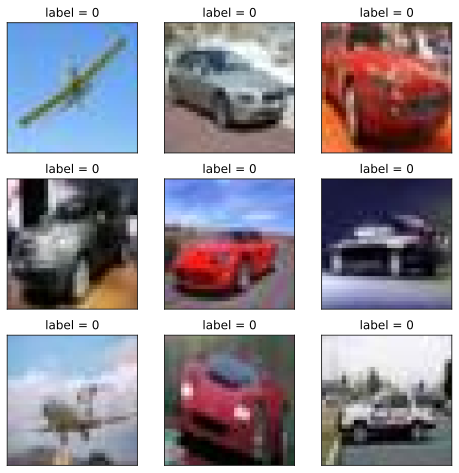

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Enable interactive mode
plt.ion()

plt.figure(figsize=(8, 8))
for i, (img, label) in enumerate(ds_train.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


In [26]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


### 2. Model Definition


Usually there are three ways of modeling using APIs of Keras: sequential modeling using Sequential() function, arbitrary modeling using API functions, and customized modeling by inheriting base class Model.

Here we use API functions for modeling.

In [27]:
tf.keras.backend.clear_session() #Clearing the session

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0     

### 3. Model Training

There are three usual ways for model training: use internal function fit, use internal function train_on_batch, and customized training loop. Here we introduce the simplist way: using internal function fit.

In [28]:
import datetime

logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Epoch 1/10
100/100 [==============================] - 19s 163ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 4.2288e-13 - val_accuracy: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 110ms/step - loss: 1.3578e-11 - accuracy: 1.0000 - val_loss: 4.2193e-13 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 129ms/step - loss: 1.1464e-11 - accuracy: 1.0000 - val_loss: 4.2193e-13 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 107ms/step - loss: 1.1611e-11 - accuracy: 1.0000 - val_loss: 4.2193e-13 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 104ms/step - loss: 1.5335e-11 - accuracy: 1.0000 - val_loss: 4.2192e-13 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 11s 107ms/step - loss: 1.4700e-11 - accuracy: 1.0000 - val_loss: 4.2191e-13 - val_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 14s 135ms/step - loss: 1.4177e-1

### 4. Model Evaluation

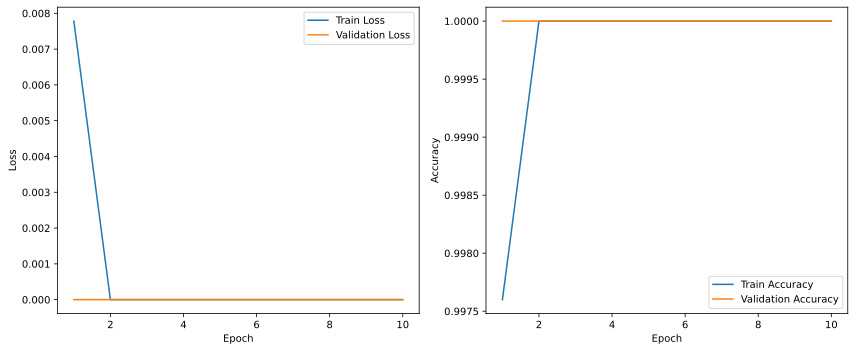

In [29]:
# Get the metrics from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Create a plot with two subplots, one for loss and one for accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### you can also use Tensorboard for the Model evaluation

In [30]:
# %load_ext tensorboard
# %tensorboard --logdir ./data/keras_model

In [31]:
# from tensorboard import notebook
# notebook.list() 

In [32]:
# #Checking model in tensorboard
# notebook.start("--logdir ./data/keras_model")

# 1-3 Example: Modeling Procedure for Texts (Day-3)
 

### 1. Data Preparation


The purpose of the imdb dataset is to predict the emotion label according to the movie reviews.

There are 20000 text reviews in the training dataset and 5000 in the testing dataset, with half positive and half negative, respectively.

The pre-processing of the text dataset is a little bit complex, which includes word division (for Chinese only, not relevant to this demonstration), dictionary construction, encoding, sequence filling, and data pipeline construction, etc.

There are two popular mothods of text preparation in TensorFlow.

The first one is constructing the text data generator using Tokenizer in `tf.keras.preprocessing`, together with `tf.keras.utils.Sequence`.

The second one is using `tf.data.Dataset` to have it work with the pre-processing layer `tf.keras.layers.experimental.preprocessing.TextVectorization`.

The former is more complex and is demonstrated [here](https://zhuanlan.zhihu.com/p/67697840).

The latter is the original method of TensorFlow, which is simpler.

Below is the introduction to the second method.


In [33]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers,preprocessing,optimizers,losses,metrics
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re,string

In [34]:
train_data_path = "/kaggle/input/imdb-reviews-dataset/train.csv"
test_data_path =  "/kaggle/input/imdb-reviews-dataset/test.csv"

In [35]:
MAX_WORDS = 10000  # Consider the 10000 words with the highest frequency of appearance
MAX_LEN = 200  # For each sample, preserve the first 200 words
BATCH_SIZE = 20 

In [36]:
#Constructing data pipeline
def split_line(line):
    arr = tf.strings.split(line,"\t")
    label = tf.expand_dims(tf.cast(tf.strings.to_number(arr[0]),tf.int32),axis = 0)
    text = tf.expand_dims(arr[1],axis = 0)
    return (text,label)


In [37]:
ds_train_raw =  tf.data.TextLineDataset(filenames = [train_data_path]) \
   .map(split_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)

ds_test_raw = tf.data.TextLineDataset(filenames = [test_data_path]) \
   .map(split_line,num_parallel_calls = tf.data.experimental.AUTOTUNE) \
   .batch(BATCH_SIZE) \
   .prefetch(tf.data.experimental.AUTOTUNE)


In [38]:
#Constructing dictionary
def clean_text(text):
    lowercase = tf.strings.lower(text)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    cleaned_punctuation = tf.strings.regex_replace(stripped_html,
         '[%s]' % re.escape(string.punctuation),'')
    return cleaned_punctuation


In [39]:
vectorize_layer = TextVectorization(
    standardize=clean_text,
    split = 'whitespace',
    max_tokens=MAX_WORDS-1, #Leave one item for the placeholder
    output_mode='int',
    output_sequence_length=MAX_LEN)


In [40]:
ds_text = ds_train_raw.map(lambda text,label: text)
vectorize_layer.adapt(ds_text)
print(vectorize_layer.get_vocabulary()[0:100])

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'his', 'are', 'have', 'be', 'he', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some', 'there', 'what', 'good', 'more', 'when', 'very', 'she', 'even', 'my', 'no', 'would', 'up', 'time', 'only', 'which', 'story', 'really', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we', 'much', 'well', 'get', 'been', 'will', 'into', 'people', 'also', 'other', 'do', 'bad', 'because', 'great', 'first', 'how', 'him', 'most', 'dont', 'made', 'then', 'them', 'films', 'movies', 'way', 'make', 'could', 'too', 'any']


In [41]:
#Word encoding
ds_train = ds_train_raw.map(lambda text,label:(vectorize_layer(text),label)) \
    .prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test_raw.map(lambda text,label:(vectorize_layer(text),label)) \
    .prefetch(tf.data.experimental.AUTOTUNE)

### 2. Model Definition


Usually there are three ways of modeling using APIs of Keras: sequential modeling using Sequential() function, arbitrary modeling using API functions, and customized modeling by inheriting base class Model.

In this example, we use customized modeling by inheriting base class Model.

In [42]:
# Actually, modeling with sequential() or API functions should be priorized.

tf.keras.backend.clear_session()

class CnnModel(models.Model):
    def __init__(self):
        super(CnnModel, self).__init__()
        
    def build(self,input_shape):
        self.embedding = layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN)
        self.conv_1 = layers.Conv1D(16, kernel_size= 5,name = "conv_1",activation = "relu")
        self.pool = layers.MaxPool1D()
        self.conv_2 = layers.Conv1D(128, kernel_size=2,name = "conv_2",activation = "relu")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1,activation = "sigmoid")
        super(CnnModel,self).build(input_shape)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.conv_1(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dense(x)
        return(x)
    
model = CnnModel()
model.build(input_shape =(None,MAX_LEN))
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  70000     
                                                                 
 conv_1 (Conv1D)             multiple                  576       
                                                                 
 max_pooling1d (MaxPooling1D  multiple                 0         
 )                                                               
                                                                 
 conv_2 (Conv1D)             multiple                  4224      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  6145      
                                                         

### 3. Model Training

There are three usual ways for model training: use internal function fit, use internal function train_on_batch, and customized training loop. Here we use the customized training loop.

In [43]:
#Temporal mark
@tf.function
def printbar():
    ts = tf.timestamp()
    today_ts = ts%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8,end = "")
    tf.print(timestring)

In [44]:
optimizer = optimizers.Nadam()
loss_func = losses.BinaryCrossentropy()

train_loss = metrics.Mean(name='train_loss')
train_metric = metrics.BinaryAccuracy(name='train_accuracy')

valid_loss = metrics.Mean(name='valid_loss')
valid_metric = metrics.BinaryAccuracy(name='valid_accuracy')


In [45]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features,training = True)
        loss = loss_func(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)
    

@tf.function
def valid_step(model, features, labels):
    predictions = model(features,training = False)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)

In [46]:
def train_model(model,ds_train,ds_valid,epochs):
    for epoch in tf.range(1,epochs+1):
        
        for features, labels in ds_train:
            train_step(model,features,labels)

        for features, labels in ds_valid:
            valid_step(model,features,labels)
        
        #The logs template should be modified according to metric
        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}' 
        
        if epoch%1==0:
            printbar()
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
            tf.print("")
        
        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()

train_model(model,ds_train,ds_test,epochs = 6)

================================================================================21:07:42
Epoch=1,Loss:0.441932,Accuracy:0.7617,Valid Loss:0.329554319,Valid Accuracy:0.8588

================================================================================21:07:53
Epoch=2,Loss:0.226987243,Accuracy:0.91205,Valid Loss:0.33309871,Valid Accuracy:0.8704

================================================================================21:08:05
Epoch=3,Loss:0.146826699,Accuracy:0.9449,Valid Loss:0.420013309,Valid Accuracy:0.8622

================================================================================21:08:16
Epoch=4,Loss:0.0814074278,Accuracy:0.9724,Valid Loss:0.554923117,Valid Accuracy:0.8602

================================================================================21:08:28
Epoch=5,Loss:0.0362747833,Accuracy:0.98895,Valid Loss:0.816165328,Valid Accuracy:0.8558

================================================================================21:08:50
Epoch=6,Loss:0.0217346512,Accur

### 4. Model Evaluation

The model trained by the customized looping is not compiled, so the method `model.evaluate(ds_valid)` can not be applied directly.

In [47]:
def evaluate_model(model,ds_valid):
    for features, labels in ds_valid:
         valid_step(model,features,labels)
    logs = 'Valid Loss:{},Valid Accuracy:{}' 
    tf.print(tf.strings.format(logs,(valid_loss.result(),valid_metric.result())))
    
    valid_loss.reset_states()
    train_metric.reset_states()
    valid_metric.reset_states()

In [48]:
evaluate_model(model,ds_test)

Valid Loss:1.04752994,Valid Accuracy:0.8476


### 5. Model Application


Below are the available methods:

* model.predict(ds_test)
* model(x_test)
* model.call(x_test)
* model.predict_on_batch(x_test)

We recommend the method `model.predict(ds_test)` since it can be applied to both Dataset and Tensor.

In [49]:
model.predict(ds_test)

250/250 [==============================] - 1s 4ms/step


array([[6.5774552e-04],
       [9.9999946e-01],
       [9.9991834e-01],
       ...,
       [6.6683185e-01],
       [1.2885843e-02],
       [1.0000000e+00]], dtype=float32)

In [50]:
for x_test,_ in ds_test.take(1):
    print(model(x_test))
    #Indentical expressions:
    #print(model.call(x_test))
    #print(model.predict_on_batch(x_test))

tf.Tensor(
[[6.5774645e-04]
 [9.9999946e-01]
 [9.9991834e-01]
 [2.8635590e-05]
 [9.8977292e-01]
 [1.9326932e-03]
 [2.5329011e-06]
 [1.5477669e-08]
 [9.9999535e-01]
 [9.9307275e-01]
 [9.9999768e-01]
 [9.9999481e-01]
 [2.0164941e-06]
 [9.9996912e-01]
 [9.0858099e-05]
 [6.7597874e-02]
 [1.6012466e-07]
 [1.3716479e-01]
 [1.8529843e-07]
 [9.9925280e-01]], shape=(20, 1), dtype=float32)


### 6. Model Saving

Model saving with the original way of TensorFlow is recommended.

In [51]:
model.save('./tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./tf_model_savedmodel')
model_loaded.predict(ds_test)

export saved model.
250/250 [==============================] - 1s 5ms/step


array([[6.5774552e-04],
       [9.9999946e-01],
       [9.9991834e-01],
       ...,
       [6.6683185e-01],
       [1.2885843e-02],
       [1.0000000e+00]], dtype=float32)

# 1-4 Example: Modeling Procedure for Temporal Sequences


The COVID-19 has been lasting for over three months (Note from the translator: until April, 2020) in China and significantly affected the ordinary life.

The impacts could be on the incomes, emotions, psychologies, and weights.

So how long this pandemic is going to last, and when will we be free again?

This example is about predicting the time of COVID-19 termination in China using RNN model established by TensorFlow 2.


### 1. Data Preparation


In [52]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 

In [53]:
df = pd.read_csv("/kaggle/input/covid-19-daily-statistics/covid-19.csv",sep = "\t")

In [54]:
fig = px.line(df, x="date", y=["confirmed_num", "cured_num", "dead_num"], labels={"value": "Cases"}, 
              title="COVID-19 Daily Statistics", template="plotly_white")

fig.update_xaxes(tickangle=60)
fig.show()

In [55]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

In [56]:
fig = px.line(dfdiff, x="date", y=["confirmed_num", "cured_num", "dead_num"], 
              labels={"value": "Daily Changes"}, title="Daily Changes in COVID-19 Cases", template="plotly_white")

fig.update_xaxes(tickangle=60)
fig.show()

In [57]:
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [58]:
#Use the data of an eight-day window priorier of the date we are investigating as input for prediction
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#We can put all data into one batch to enhance the performance since the data volume is small.
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

### 2. Model Definition


Usually there are three ways of modeling using APIs of Keras: sequential modeling using Sequential() function, arbitrary modeling using API functions, and customized modeling by inheriting base class Model.

Here we use API functions for modeling.

In [59]:
#We design the following block since the daily increment of confirmed, discharged and deceased cases are equal or larger than zero.
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [60]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#We design the following block since the daily increment of confirmed, discharged and deseased cases are equal or larger than zero.
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 3)      84          ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, None, 3)      84          ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  (None, None, 3)      84          ['lstm_1[0][0]']                 
                                                                                              

### 3. Model Training

There are three usual ways for model training: use internal function fit, use internal function train_on_batch, and customized training loop. Here we use the simplist way: using internal function fit.

Note: The parameter adjustment of RNN is more difficult comparing to other types of neural network. We need to try various learning rate to achieve a satisfying result.

In [61]:
#Customized loss function, consider the ratio between square error and the prediction
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

logdir = "./keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#Half the learning rate if loss is not improved after 100 epoches
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#Stop training when loss is not improved after 200 epoches
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 9s 9s/step - loss: 2.7162 - lr: 0.0100
Epoch 2/500
1/1 [==============================] - 0s 116ms/step - loss: 2.2908 - lr: 0.0100
Epoch 3/500
1/1 [==============================] - 0s 117ms/step - loss: 1.9277 - lr: 0.0100
Epoch 4/500
1/1 [==============================] - 0s 125ms/step - loss: 1.5536 - lr: 0.0100
Epoch 5/500
1/1 [==============================] - 0s 116ms/step - loss: 1.1956 - lr: 0.0100
Epoch 6/500
1/1 [==============================] - 0s 117ms/step - loss: 0.8801 - lr: 0.0100
Epoch 7/500
1/1 [==============================] - 0s 114ms/step - loss: 0.6313 - lr: 0.0100
Epoch 8/500
1/1 [==============================] - 0s 116ms/step - loss: 0.4675 - lr: 0.0100
Epoch 9/500
1/1 [==============================] - 0s 116ms/step - loss: 0.3966 - lr: 0.0100
Epoch 10/500
1/1 [==============================] - 0s 118ms/step - loss: 0.4098 - lr: 0.0100
Epoch 11/500
1/1 [==============================] - 0s 120ms/step - loss

### 4. Model Evaluation


Model evaluation usually needs both evaluation and testing sets. We only have very few data in this case so we only visualize the changes of loss function during iteration.m

In [63]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)

    df = pd.DataFrame({
        'Epochs': epochs,
        'train_' + metric: train_metrics
    })

    fig = px.line(df, x='Epochs', y='train_' + metric, labels={'train_' + metric: metric},
                  title='Training ' + metric, template='plotly_white')

    fig.show()


In [64]:
plot_metric(history,"loss")

### 5. Model Application


We predict the time of the end of COVID-19 here, i.e. the date when the daily increment of new confirmed cases = 0.


In [65]:
#This "dfresult" is used to record the current and predicted data
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [66]:
#Predicting the daily increment of the new confirmed cases of the next 100 days; add this result into dfresult
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

1/1 [==============================] - 0s 30ms/step


/tmp/ipykernel_20/3810038479.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



1/1 [==============================] - 0s 30ms/step


In [67]:
dfresult.query("confirmed_num==0").head()

# From Day 55 the daily increment of the new confirmed cases reduced to zero. Since Day 45 is corresponding to March 10, the daily increment of the news confirmed cases will reduce to 0 in Manch 20.
# Note: this prediction is TOO optimistic

,confirmed_num,cured_num,dead_num
50,0.0,1369.0,0.0
51,0.0,1384.0,-0.0
52,0.0,1399.0,0.0
53,0.0,1414.0,-0.0
54,0.0,1429.0,0.0


In [68]:
dfresult.query("dead_num==0").head()

# The daily increment of the deceased will be reduced to 0 from Day 60, which is March 25, 2020
# Note: This prediction is relatively reasonable.

,confirmed_num,cured_num,dead_num
46,9.0,1311.0,0.0
47,4.0,1325.0,-0.0
48,2.0,1339.0,0.0
49,1.0,1354.0,-0.0
50,0.0,1369.0,0.0



### 6. Model Saving


Model saving with the original way of TensorFlow is recommended.****

In [69]:
model.save('./tf_model_savedmodel', save_format="tf")
print('export saved model.')

export saved model.


In [70]:
model_loaded = tf.keras.models.load_model('./tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

2/2 [==============================] - 2s 31ms/step


array([[1103.2532  ,   87.724655,    0.      ],
       [1360.8016  ,   68.7841  ,    0.      ],
       [1484.8453  ,  146.54005 ,    0.      ],
       [1699.2937  ,  156.50876 ,    0.      ],
       [2042.5164  ,  259.1865  ,    0.      ],
       [1941.5995  ,  260.18335 ,    0.      ],
       [1651.9889  ,  385.78912 ,    0.      ],
       [1779.1863  ,  508.40427 ,    0.      ],
       [1393.9149  ,  597.1258  ,    0.      ],
       [1562.6354  ,  630.0225  ,    0.      ],
       [1296.6772  ,  712.7628  ,    0.      ],
       [1059.102   ,  741.6721  ,    0.      ],
       [7963.5015  , 1167.336   ,    0.      ],
       [2127.1394  ,  809.45935 ,    0.      ],
       [1388.1333  , 1368.704   ,    0.      ],
       [1055.4227  , 1318.8605  ,    0.      ],
       [1076.4471  , 1420.5414  ,    0.      ],
       [ 992.19495 , 1702.6886  ,    0.      ],
       [ 919.18756 , 1818.3407  ,    0.      ],
       [ 205.52496 , 1773.4791  ,    0.      ],
       [ 467.41098 , 2102.4321  ,    0. 

Thank you for joining the "Eat That TensorFlow2.0 in 30 Days" series - happy learning and keep exploring the world of TensorFlow! 🙏🚀